In [1]:
import skimage.io

import itertools
import sys

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.integrate

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting

import bebi103

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# Pevent bulky altair plots
alt.data_transformers.enable('json')

# A whole bunch of skimage stuff
import skimage.feature
import skimage.filters
import skimage.filters.rank
import skimage.io
import skimage.morphology
import skimage.segmentation


Loading BokehJS ...

## Problem 3.2.b

The files bacterium_1.tif and bacterium_2.tif are TIFF stacks of time courses for specific cells in from the full field images. From these time courses, determine the bacterial area for each time point. Assign each time point with an identifier for which division it is. This means you need to determine when divisions happen.

We start by copying a function from tutorial 4b that allows us to display two images side by side. This will be helpful in checking the results of our segmentations.

In [2]:
def show_two_ims(im_1, im_2, titles=[None, None],
                 interpixel_distances=[0.065, 0.065], color_mapper=None):
    """Convenient function for showing two images side by side."""
    p_1 = bebi103.viz.imshow(im_1,
                             plot_height=300,
                             title=titles[0],
                             color_mapper=color_mapper,
                             interpixel_distance=interpixel_distances[0],
                             length_units='µm')
    p_2 = bebi103.viz.imshow(im_2,
                             plot_height=300,
                             title=titles[1],
                             color_mapper=color_mapper,
                             interpixel_distance=interpixel_distances[1],
                             length_units='µm')
    p_2.x_range = p_1.x_range
    p_2.y_range = p_1.y_range

    return bokeh.layouts.gridplot([p_1, p_2], ncols=2)

We load in the first bacterium.

In [3]:
# Define directory containing files
im_file = '../data/iyer_biswas_et_al/bacterium_1.tif'

# So we have it, the interpixel distance
ip = 0.052  # microns

# Get image file
im = skimage.io.imread(im_file)

We display the raw image of a random frame to see what we are looking at. We'll use it to perfect our segmentation pipeline, and then apply that segmentation pipeline to ALL the rest of the 1900 images in the frame and the other bacterium.

In [4]:
# For now, let's look at the first frame
i = 0

# Display raw images
plot = bebi103.viz.imshow(im[i],
                            plot_height=300,
                            title=im_file,
                            interpixel_distance=ip,
                            length_units='µm')
bokeh.io.show(plot)

First, we tried using Canny Edge Detection. However, since we first find the edges and then fill the shapes in, we join the cells back together which isn't our final goal. The result is suseptible to noise. In our case, cells were not shaded in accurately enough for our needs, so we abondoned this method in favor of the Laplacian of Gaussian and zero crossing method.

In [5]:
# Convert image to float
im_float = (im[i].astype(float) - im[i].min()) / (im[i].max() - im[i].min())

Now we need to fill in the gaps in the edges!

In [8]:
# Fill the holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_float)

# Look at result
bokeh.io.show(show_two_ims(im_float,
                           im_bw,
                           titles=['original', 'segmented']))


In [10]:
# Close the edge image
selem = skimage.morphology.disk(2)
im_edge_closed = skimage.morphology.binary_closing(im_float, selem)

# Fill these holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)

# Check out results
bokeh.io.show(show_two_ims(im_float,
                           im_bw,
                           titles=['original', 'segmented']))

In [11]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)

# Check out results
bokeh.io.show(
    bebi103.viz.imshow(im_LoG,
                       color_mapper=bebi103.viz.mpl_cmap_to_color_mapper('bwr'),
                       interpixel_distance=ip,
                       length_units='µm',
                       colorbar=True))

In [12]:
# 3x3 square structuring element
selem = skimage.morphology.square(3)
    
# Do max filter and min filter
im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

# Image of zero-crossings
im_edge = (  ((im_LoG >= 0) & (im_LoG_min < 0)) 
           | ((im_LoG <= 0) & (im_LoG_max > 0)))

# Show result
bokeh.io.show(show_two_ims(im_float,
                           im_edge,
                           titles=['original', 'edges']))

We use the zero_crossing_filter function defined in the tutorial to find the zero crossings of our data and display the result. We tested out several different thresholds, and found that 0.005 segmented the most bacteria correctly.

In [13]:
def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return ( (  ((im >= 0) & (im_min < 0))
              | ((im <= 0) & (im_max > 0))) 
            & (im_grad >= thresh) )

In [17]:
# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.005)

# Show result
bokeh.io.show(show_two_ims(im_float,
                           im_edge,
                           titles=['original', 'edges']))

We first try to skeletonize the edges without closing the edge image using a morphology disk. The edges are not closed properly! We found that when we graphed area vs label for all frames, frames with labels greater than about 1000 were not segmented properly.

In [15]:
# Skeletonize edges
im_edge_temp = skimage.morphology.skeletonize(im_edge)

# See result
bokeh.io.show(show_two_ims(im_float,
                           im_edge_temp,
                           titles=['original', 'edges']))

We now add edge closing to mitigate this issue. It makes sense to do this before we skeletonize because edges are easier to close when they are thicker! 

In [18]:
# Close the edge image
selem_disk = skimage.morphology.disk(3)
im_edge = skimage.morphology.binary_closing(im_edge, selem_disk)

# Skeletonize edges
im_edge = skimage.morphology.skeletonize(im_edge)

# See result
bokeh.io.show(show_two_ims(im_float,
                           im_edge,
                           titles=['original', 'edges']))

In [19]:
# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

# Show result
bokeh.io.show(show_two_ims(im_float,
                           im_bw,
                           titles=['original', 'segmented']))


In [20]:
# Clear border with large buffer size b/c LoG procedure came off border
im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

# Show result
bokeh.io.show(
    bebi103.viz.imshow(im_bw, 
                       color_mapper=bebi103.viz.mpl_cmap_to_color_mapper('gray'),
                       interpixel_distance=ip,
                       length_units='µm'))

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


In [21]:
# Label binary image; backward kwarg says value in im_bw to consider backgr.
im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)

# Show number of bacteria
print('Number of individual bacteria = ', n_labels)

# See result (one of the few times it's ok to use rainbow colormap!)
bokeh.io.show(
    bebi103.viz.imshow(im_labeled, 
                       color_mapper=bebi103.viz.mpl_cmap_to_color_mapper('rainbow'),
                       interpixel_distance=ip,
                       length_units='µm'))

Number of individual bacteria =  1


We get the intensity image so we can get information about the area of the bacterium.

In [24]:
# Load images and store in list [phase, RFP, CFP, YFP]
im_y = skimage.io.imread('../data/iyer_biswas_et_al/bacterium_1.tif')

# Upsample (2 means 2x as big, order=0 means no interpolation)
im_y = scipy.ndimage.zoom(im_y[180], 1, order=0)

# Get properties about the YFP channel
im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)

We extract the label and the area of the bacterium in a easy to read/process format. This one looks nice! There is only one bacterium detected, but this will not always be the case!

In [25]:
data = [[prop.label, prop.area] for prop in im_y_props]
df = pd.DataFrame(data=data, columns=['label', 'area (sq µm)'])

# Take a look
df.head()

,label,area (sq µm)
0,1,595


Now that we have the number of bacteria (or noise) in each image, we can start calculating the area at each frame. If the number of blobs is greater than 1, we will need to filter out the noise to isolate our desired bacterium.

There are several options for doing this:

- pick the bacterium with the largest area
- pick the area nearest to the previous center (the main bacterium is stationary)
- pick the rightmost area (once again, the bacterium we want to isolate is stationary on the far right)

For our purposes, it is sufficient to just pick the blob with the largest area.

Once we have identified the bacterium, we will count the number of pixels to get the area of each frame and store it in an array. We create a function Laplacian of Gaussian (l_o_g) that takes an individual frame and returns the area of the largest blob in the image. We include all the image segmentation code we have found to be the most effective in our exploration above. 

In [185]:
def l_o_g(image, show = False):
    
    # "Show" tells the function which image to display along with the areas, the unsegmented image 
    # (show = image), the edges image (show = edges), or the final image on which the area was 
    # calculated (show = labeled)
    
    
    # Convert image to float
    im_float = (image.astype(float) - image.min()) / (image.max() - image.min())
    
    # Display if asked
    if show == "image":
        bokeh.io.show(
        bebi103.viz.imshow(im_float, 
                           color_mapper=bebi103.viz.mpl_cmap_to_color_mapper('rainbow'),
                           interpixel_distance=ip,
                           length_units='µm'))
    
    # Compute LoG
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)

    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = (  ((im_LoG >= 0) & (im_LoG_min < 0)) 
               | ((im_LoG <= 0) & (im_LoG_max > 0)))
    
    # Find zero-crossings
    im_edge = zero_crossing_filter(im_LoG, 0.005)

    # Close the edge image
    selem_disk = skimage.morphology.disk(3)
    im_edge = skimage.morphology.binary_closing(im_edge, selem_disk)
    
    # Skeletonize edges
    im_edge = skimage.morphology.skeletonize(im_edge)
    
    # Display if asked
    if show == "edge":
        bokeh.io.show(
        bebi103.viz.imshow(im_edge, 
                           color_mapper=bebi103.viz.mpl_cmap_to_color_mapper('rainbow'),
                           interpixel_distance=ip,
                           length_units='µm'))
    
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)
    
    # Clear border with large buffer size b/c LoG procedure came off border
    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    
    # Label binary image; backward kwarg says value in im_bw to consider backgr.
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    # Display if asked
    if show == "labeled":
        bokeh.io.show(
        bebi103.viz.imshow(im_labeled, 
                           color_mapper=bebi103.viz.mpl_cmap_to_color_mapper('rainbow'),
                           interpixel_distance=ip,
                           length_units='µm'))
    
    # Upsample (2 means 2x as big, order=0 means no interpolation)
    im_y = scipy.ndimage.zoom(image, 1, order=0)
    
    # Get properties about the YFP channel
    im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)
    
    # seperate it to make the results more readable
    data = [[prop.label, prop.area] for prop in im_y_props]
    
    if len(data) == 1:
        return data[0][1]
    
    # We are interested in looking at the largest bacterium in our image
    if len(data) > 1:
        max_area = data[0][1]
        max_bac = data[0] 
        for d in data:
            if d[1] > max_area:
                max_area = d[1]
                max_bac = d
        return max_area
    return None
    

We also need to find when divisions occur! We were having lots of problems with our segmentation pipeline classifying one frame of a almost divided bacteria as 2 bacterium and then the next as 1 bacterium, causing extraneous division events to be recorded, so we wrote a function to check if the division is real or not.

In [177]:
"""This function determines whether a given index of a dataframe 
is an outlier. """
def isnt_outlier(df, index, thresh):
    # We begin by defining the indices on either side of our point of interest
    prepre = index - 2
    pre = index - 1
    post = index + 1
    
    # We don't care about points that are on the edges of the dataframe
    # because we can't see what comes before/after the points.
    if pre < 0:
        return False
    elif post == len(df):
        return False
    
    # Define the area at the three points
    pre_int = df['area (sq µm)'].iloc[pre]
    our_int = df['area (sq µm)'].iloc[index]
    post_int = df['area (sq µm)'].iloc[post]
    
    if pre_int < 350 or pd.isnull(pre_int):
        pre_int = df['area (sq µm)'].iloc[prepre]

    Is_division = pre_int - our_int > thresh
    Post_outlier = post_int - our_int < 200
    
    return Is_division and Post_outlier

In [226]:
def find_divisions(df, threshold):
    THRESHOLD = threshold
    num_divisions = 0
    division_events = []
    division_times = []

    prev_division = 0
    prev_divison = 0

    for index, row in df.iterrows():
        # take the previous area so you can compare the difference and find division events
        if index != 0:
            # A division has occured
            if isnt_outlier(df, index, THRESHOLD) and index - prev_division > 25:
                num_divisions += 1
                division_events.append(num_divisions)
                division_times.append(index - prev_division)
                prev_division = index

            else:
                division_events.append(0)
                division_times.append(0)

        else:
            division_events.append(0)
            division_times.append(0)

        
    return (division_events, division_times )


We run this segmentation pipeline and the division functions on all the frames of bacterium 1 and store the resulting areas in an dataframe. This is a long computation and we want to use the results later, so we will use a try block to save us computation time in re-running this code over and over.

In [174]:
try:
    # This executes if we have already done the computation
    df_bac1 = pd.read_csv("./bac_1_areas.csv")
    df_bac1 = df_bac1.drop(["Unnamed: 0"], axis = 1)
except:
    areas_bac1 = []
    for i in range(len(im - 1)):
        # Loading bar!
        sys.stdout.write("\r%.2f percent done."%(100 * i/(len(im - 1))))
        areas_bac1.append([i, l_o_g(im[i])])
    df_bac1 = pd.DataFrame(data=areas_bac1, columns=['label', 'area (sq µm)'])
    division_events, division_times = find_divisions(df_bac1, 450)
    df_bac1["division_number"] = division_events
    df_bac1["division_period"] = division_times
    df_bac1.to_csv("./bac_1_areas.csv")
    

In [175]:
areas_bac1 = []
for i in range(len(im - 1)):
    # Loading bar!
    sys.stdout.write("\r%.2f percent done."%(100 * i/(len(im - 1))))
    areas_bac1.append([i, l_o_g(im[i])])
df_bac1 = pd.DataFrame(data=areas_bac1, columns=['label', 'area (sq µm)'])
division_events, division_times = find_divisions(df_bac1, 350)
df_bac1["division_number"] = division_events
df_bac1["division_period"] = division_times
df_bac1.to_csv("./bac_1_areas.csv")
    

1.79 percent done.

KeyboardInterrupt: 

In [179]:
division_events, division_times = find_divisions(df_bac1, 350)
df_bac1["division_number"] = division_events
df_bac1["division_period"] = division_times

In [180]:
df_bac1.head()

,label,area (sq µm),division_number,division_period
0,0,595.0,0,0
1,1,603.0,0,0
2,2,617.0,0,0
3,3,616.0,0,0
4,4,611.0,0,0


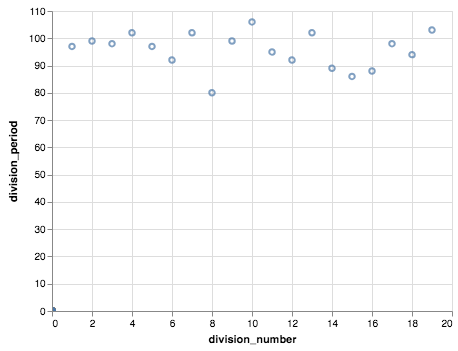

In [181]:
alt.Chart(df_bac1).mark_point().encode(
    x='division_number',
    y='division_period',
    tooltip=['label', 'division_number', 'division_period']
).interactive()

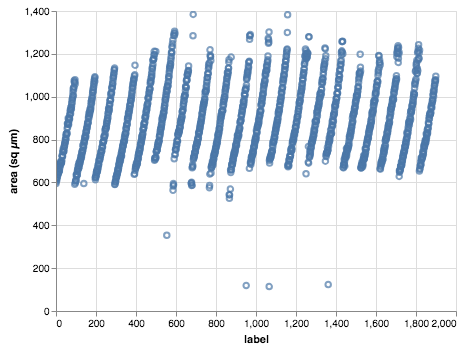

In [143]:
alt.Chart(df_bac1).mark_point().encode(
    x='label',
    y='area (sq µm)',
).interactive()

In [161]:
l_o_g(im[1066], "labeled")

114

In [141]:
l_o_g(im[1266], "labeled")

In [147]:
l_o_g(im[1435], "labeled")

Bug list: 
- 0: Maybe count automatically? Or what?
- 1066: Wrong edges
- 1266: NaN
- 1435: NaN


In [182]:
# Define directory containing files
im_file2 = '../data/iyer_biswas_et_al/bacterium_2.tif'

# So we have it, the interpixel distance
ip = 0.052  # microns

# Get image file
im2 = skimage.io.imread(im_file2)

In [219]:
try:
    # This executes if we have already done the computation
    df_bac2 = pd.read_csv("./bac_2_areas.csv")
except:
    areas_bac2 = []
    for i in range(len(im2 - 1)):
        # Loading bar!
        sys.stdout.write("\r%.2f percent done."%(100 * i/(len(im2 - 1))))
        areas_bac2.append([i, l_o_g(im2[i])])
    df_bac2 = pd.DataFrame(data=areas_bac2, columns=['label', 'area (sq µm)'])
    division_events, division_times = find_divisions(df_bac2, 450)
    df_bac2["division_number"] = division_events
    df_bac2["division_period"] = division_times
    df_bac2.to_csv("./bac_2_areas.csv")

In [227]:
division_events, division_times = find_divisions(df_bac2, 450)
df_bac2["division_number"] = division_events
df_bac2["division_period"] = division_times

In [191]:
len(areas_bac1)

8735

In [193]:
df_bac12 = pd.DataFrame(data=areas_bac1, columns=['label', 'area (sq µm)'])
division_events, division_times = find_divisions(df_bac12, 450)
df_bac12["division_number"] = division_events
df_bac12["division_period"] = division_times
df_bac12.to_csv("./bac_12_areas.csv")

In [202]:
len(im2-1)

8700

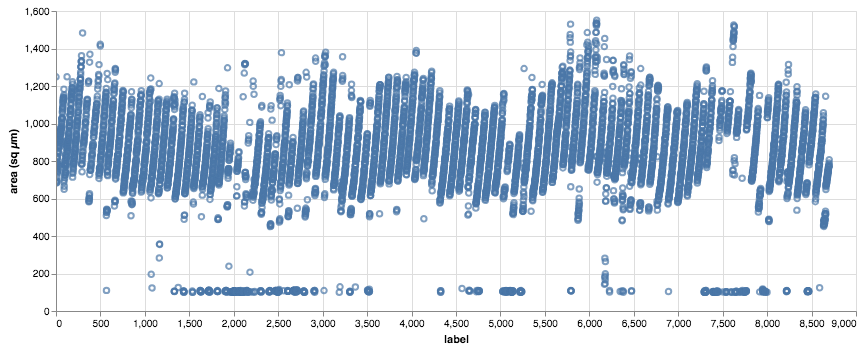

In [232]:
alt.Chart(df_bac2).mark_point().encode(
    x='label',
    y='area (sq µm)'
).properties(height = 300, width = 800).interactive()

In [241]:
l_o_g(im2[7700], "labeled")

102

In [204]:
df_bac12.drop(df_bac12[0:34])

,label,area (sq µm),division_number,division_period
0,0,595.0,0,0
1,1,603.0,0,0
2,2,617.0,0,0
3,3,616.0,0,0
4,4,611.0,0,0
5,5,624.0,0,0
6,6,634.0,0,0
7,7,625.0,0,0
8,8,640.0,0,0
9,9,636.0,0,0


In [209]:
df_bac2 = df_bac12[df_bac12.index > 34]

In [214]:
df_bac2 = df_bac2.reset_index()

In [216]:
division_events, division_times = find_divisions(df_bac2, 350)
df_bac2["division_number"] = division_events
df_bac2["division_period"] = division_times
df_bac2.to_csv("./bac_2_areas.csv")

In [217]:
df_bac2

,label,area (sq µm),division_number,division_period
0,0,1249.0,0,0
1,1,759.0,0,0
2,2,750.0,0,0
3,3,764.0,0,0
4,4,771.0,0,0
5,5,682.0,0,0
6,6,686.0,0,0
7,7,775.0,0,0
8,8,692.0,0,0
9,9,697.0,0,0
